<a href="https://colab.research.google.com/github/HolyBayes/HSE_Intro2DL2021/blob/master/sem2.1-solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Распознавание карт лояльности на Keras

In [2]:
# Сначала сделаем загрузку данных:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py -O setup_google_colab.py
from setup_google_colab import setup_week2
setup_week2()

--2021-02-02 12:31:07--  https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1109 (1.1K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.08K  --.-KB/s    in 0s      

2021-02-02 12:31:07 (95.1 MB/s) - ‘setup_google_colab.py’ saved [1109/1109]



data.zip:  17%|█▋        | 8.39M/49.1M [00:00<00:00, 81.2MB/s]

week2
/content


data.zip: 100%|██████████| 49.1M/49.1M [00:00<00:00, 182MB/s] 


 В этом ноутбуке будем работать с датасетом карт лояльности. 
 Задача: по фотографии карточки определить к какому бренду она относится

В данном ноутбуке мы разберём пример практической задачи по распазнованию бренда карты лояльности по её фотографии.

In [3]:
import numpy as np
import os
import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
PROJECT_PATH = os.getcwd()
PATH_TRAIN = os.path.join(PROJECT_PATH, 'data', 'TEMP_CODE', 'train') # путь к обучающей выборке

In [5]:
all_files = []
for root, dirs, files in os.walk(PATH_TRAIN): # пройдёмся по всем вложенным директориям и соберём все картинки
    for f in files:
        all_files.append( os.path.abspath(os.path.join(root, f)).replace("\\","/"))

Ниже приведён пример данных, на которых мы будем обучаться:

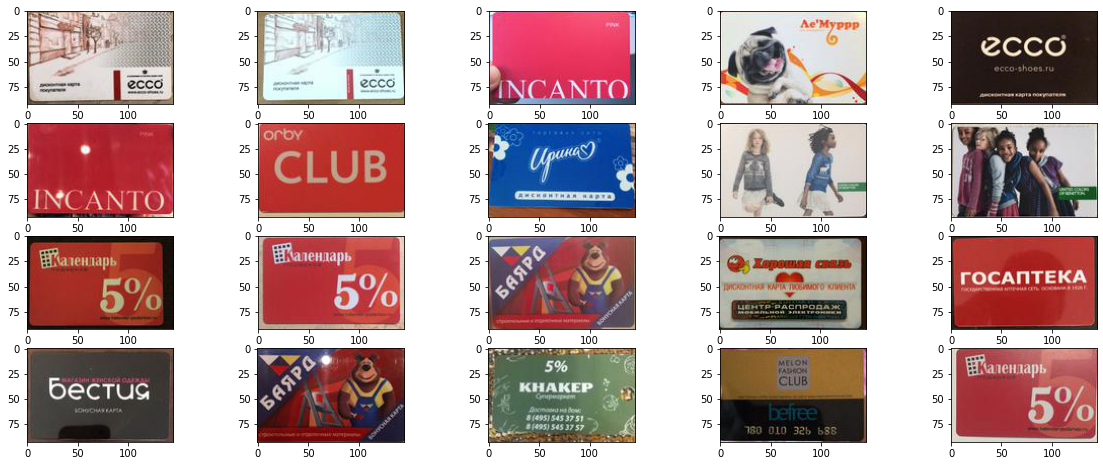

In [6]:
SIZE = 20 # число случайно выбранных карточек из обучающего датасета
selected = np.random.choice(all_files, size=SIZE)

images = []
for img_path in selected:
    #print(img_path)
    images.append(mpimg.imread(img_path))
#print(images)

plt.figure(figsize=(20,10))
columns = 5
for i, image_ in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_)

Всего в выборке 18 классов, в каждом примерно по 200 фотографий, итого примерно 3600 фотографий в обучающей выборке. В валидационной выборке те же 18 классов, для ккаждого примерно по 30 фотографий, итого 540 фотографий в валидационной выборке

In [10]:
import os
import sys
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras.utils.generic_utils import CustomObjectScope
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

def count_folders(path):
    return len(glob.glob(os.path.join(path,'*')))

def get_barcode_class(path):
    return os.path.basename(path)

In [11]:
TEST_CLASS_SIZE = 20
VAL_PATH        = 'data/TEMP_CODE/val/'
TEST_PATH       = 'data/TEMP_CODE/test/'

os.mkdir(TEST_PATH)

for dir in os.listdir(VAL_PATH):
    os.mkdir(TEST_PATH + dir)
    files = os.listdir(VAL_PATH + dir)
    random_files = np.random.choice(files, TEST_CLASS_SIZE, False)
    for random_file in random_files:
        os.replace(VAL_PATH + dir + '/' + random_file, TEST_PATH + dir + '/' + random_file)

### Объявления:

Вспомогательные объявления, например, число классов, размер батча, путь к данным и т.д.

In [13]:
args = {'batch_size': 16, 'data_path': os.path.join(PROJECT_PATH, 'data', 'TEMP_CODE'), 
        'previous_model': ''}

""" Define barcode class and underlying classes number from file structure """
NUM_CLASSES = count_folders(os.path.join(args['data_path'], 'train'))
BARCODE = get_barcode_class(args['data_path'])
SUPPORT_FILES_PATH = os.path.join(PROJECT_PATH, 'resource', BARCODE, 'support_files')
""" Define data path and output path  """
DATA_PATH = args['data_path']

""" Check if previously trained model is used """
if args['previous_model'] == '':
    TRAIN_FROM_ZERO = True
else:
    TRAIN_FROM_ZERO = False

### Модель:

Ниже следует блок с объявлением модели. Вы можете: 

1) Собрать кастомную сеть

2) Загрузить существующую сеть. Например, для импорта VGG16: ```from keras.applications import vgg16```, затем ```model = vgg16.VGG16(weights='imagenet')```. У модели можно зафиксировать веса первых n слоёв и обучать все оставшиеся

3) Загрузить модель из папки models и дообучить её. При первом запуске папка models пустая, в неё будут автоматически сохраняться модели при обучении в конце каждой эпохи

In [14]:
cat ~/.keras/keras.json

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

In [19]:
###
# <YOUR CODE GOES HERE>
# Здесь объявите свою модель
# В случае, если вы захотите загружать существующую модель из Кераса, то для того, чтобы поменять последние слои
# вам понадобятся следующие команды:
#model.layers.pop()
#model.layers[-1].output
#Model(input=model.inputs, output=x)

model = Sequential()
model.add(InputLayer((224, 224, 3)))
model.add(Conv2D(16, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(3, padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(3, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization_12 (Batc (None, 222, 222, 16)      64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 220, 220, 32)      4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 64)       

In [20]:
OUTPUT_PATH = os.path.join(PROJECT_PATH, 'models', BARCODE)
#os.makedirs(OUTPUT_PATH)

### Объявления генераторов данных:

Ниже объявим генераторы данных.
В Керасе реализован класс ImageDataGenerator, который определяет конфигурацию для подготовленных к обучению изображений, а также отвечает за аугментацию данных.
Аугументация данных происходит на лету во время обучения раз в эпоху, поэтому данные почти никогда не будут повторяться - это хорошо. И точка переобучения будет дальше - можно тренировать больше эпох.

Краткий туторила по генераторам данных из Keras: 
https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

Параметры объекта ```keras.preprocessing.image.ImageDataGenerator```: https://keras.io/preprocessing/image/

In [21]:
""" Create dataloaders """
train_datagen = image.ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range = 0.2,
    shear_range = 0.2
)
train_generator = train_datagen.flow_from_directory(
    directory = os.path.join(args['data_path'], 'train'),
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = args['batch_size'],
    class_mode = "categorical",
    shuffle = True,
    seed = 2021
)

val_datagen = image.ImageDataGenerator(
    rescale = 1. / 255
)
val_generator = val_datagen.flow_from_directory(
    directory = os.path.join(args['data_path'], 'val'),
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = args['batch_size'],
    class_mode = "categorical",
    shuffle = True,
    seed = 2021
)

test_datagen = image.ImageDataGenerator(
    rescale = 1. / 255
)
test_generator = test_datagen.flow_from_directory(
    directory = os.path.join(args['data_path'], 'test'),
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = args['batch_size'],
    class_mode = "categorical",
    shuffle = True,
    seed = 2021
)

Found 4520 images belonging to 18 classes.
Found 1896 images belonging to 18 classes.
Found 360 images belonging to 18 classes.


Делаем compile и запускаем обучение:

In [22]:
optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, decay=0.0)
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

earlystopper = EarlyStopping(patience=0)
mcp_save     = ModelCheckpoint('model_weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [23]:
STEPS_PER_EPOCH_TRAIN = train_generator.n // train_generator.batch_size
STEPS_PER_EPOCH_VALID = val_generator.n // val_generator.batch_size

### Обучение модели:

В модель передаём: генератор данных (он сам автоматически генерирует X и y), валидационную выборку (тоже посредством генератора), число эпох, коллбеки и verbose

In [25]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
    validation_data = val_generator,
    validation_steps = STEPS_PER_EPOCH_VALID,
    epochs = 4,
    verbose = 1,
    callbacks = [earlystopper, mcp_save]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
282/282 [==============================] - 52s 166ms/step - loss: 10.8477 - accuracy: 0.7142 - val_loss: 10.2571 - val_accuracy: 0.3104

Epoch 00001: val_loss improved from inf to 10.25708, saving model to model_weights.hdf5
Epoch 2/4
282/282 [==============================] - 47s 165ms/step - loss: 2.2803 - accuracy: 0.9049 - val_loss: 1.3062 - val_accuracy: 0.9333

Epoch 00002: val_loss improved from 10.25708 to 1.30623, saving model to model_weights.hdf5
Epoch 3/4
282/282 [==============================] - 47s 167ms/step - loss: 1.4782 - accuracy: 0.9267 - val_loss: 2.2558 - val_accuracy: 0.9285

Epoch 00003: val_loss did not improve from 1.30623


### Test quality

In [28]:
model.load_weights('model_weights.hdf5')
evaluation = model.evaluate_generator(test_generator)
evaluation

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.0307824611663818, 0.925000011920929]